### Data Balancing

In [123]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
import scipy as sp
from io import StringIO
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
#from sklearn.metrics import decision_function
from sklearn.metrics import roc_curve

In [3]:
X = preprocessing.scale(data.drop(['multiclass_casualties'],axis = 1))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [4]:
Y = data['multiclass_casualties']

In [138]:
#### Use Stratify = Y

# How stratify works This stratify parameter makes a split
# so that the proportion of values in the sample produced 
# will be the same as the proportion of values provided to parameter stratify.
# For example, if variable y is a binary categorical variable with values 0 and 1
# and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split
# has 25% of 0's and 75% of 1's.

# apply SMOTE only to training set, test set does not have to be balanced
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
sm = SMOTE(sampling_strategy = 'not majority')

In [139]:
x_train_balanced, y_train_balanced = sm.fit_resample(x_train, y_train)

### Decision Tree MultiClass Classifier

### Decision Tree Hyperparameter Tuning

### Default Parameters

In [140]:
default_parameters = DecisionTreeClassifier().fit(x_train_balanced, y_train_balanced)
y_pred = default_parameters.predict(x_test)

Confusion Matrix

In [59]:
array = confusion_matrix(y_test, y_pred)

In [60]:
[array[i]/sum(array[i]) for i in range(len(array))]

[array([0.91524796, 0.07957069, 0.00518135]),
 array([0.56565657, 0.35858586, 0.07575758]),
 array([0.2962963 , 0.51851852, 0.18518519])]

F1 Score

In [141]:
f1_score(y_test, y_pred, average = 'macro')

0.5306012315700422

### Tuning split and leaf without cross-validation

In [12]:
plotting_data = []
for i in min_samples_split_values:
    for j in min_samples_leaf_values:
        dt = DecisionTreeClassifier(min_samples_split = i,min_samples_leaf=j).fit(x_train_balanced, y_train_balanced)
        y_pred = dt.predict(x_test)
        row = [i ,j, f1_score(y_test, y_pred, average = 'macro')]
        plotting_data.append(row)

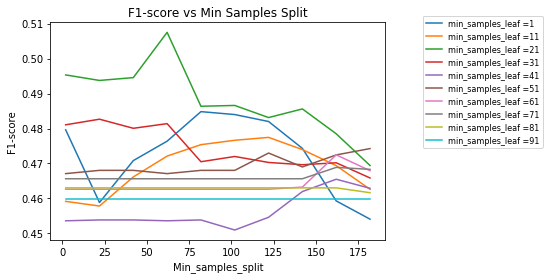

<Figure size 1080x576 with 0 Axes>

In [13]:
plotting = pd.DataFrame(plotting_data)
for i in min_samples_leaf_values:
    plt.plot(plotting[0][plotting[1] == i], plotting[2][plotting[1] == i], label = "min_samples_leaf =" + str(i))
plt.legend(prop={'size': 8}, bbox_to_anchor=(1.1, 1.05))
plt.title("F1-score vs Min Samples Split")
plt.ylabel("F1-score")
plt.xlabel("Min_samples_split")
plt.figure(figsize=(15,8))
plt.show()

In [14]:
plotting = plotting.rename(columns={ 0: 'Min_Samples_Split', 1: 'Min_Samples_Leaf', 2: 'f1_score'})

In [15]:
plotting[plotting['f1_score'] == plotting['f1_score'].max()]

,Min_Samples_Split,Min_Samples_Leaf,f1_score
32,62,21,0.507523


### Most important features are tornado_intensity', 'tornado_area' and  'minimum_range', followed by 'duration'.

### Tuning split and leaf with cross-validation

In [16]:
k = 5
plotting_data2 = []
kf = KFold(n_splits=k)    
for train_index, test_index in kf.split(x_train_balanced):
    X_cv_train, X_cv_validate = pd.DataFrame(x_train_balanced).iloc[train_index], pd.DataFrame(x_train_balanced).iloc[test_index]
    Y_cv_train, Y_cv_validate = pd.DataFrame(y_train_balanced).iloc[train_index], pd.DataFrame(y_train_balanced).iloc[test_index]
    for i in min_samples_split_values:
        for j in min_samples_leaf_values:
            dt = DecisionTreeClassifier(min_samples_split = i, min_samples_leaf=j).fit(X_cv_train, Y_cv_train)
            y_pred = dt.predict(X_cv_validate)
            row = [i ,j, f1_score(Y_cv_validate, y_pred, average = 'macro')]
            plotting_data2.append(row)            

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined an

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined an

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined an

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined an

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined an

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined an

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined an

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined an

In [17]:
plotting2 = pd.DataFrame(plotting_data2)

In [18]:
plotting2 = plotting2.rename(columns={ 0: 'Min_Samples_Split', 1: 'Min_Samples_Leaf', 2: 'f1_score'})

In [19]:
plotting2[plotting2['f1_score'] == plotting2['f1_score'].max()]

,Min_Samples_Split,Min_Samples_Leaf,f1_score
100,2,1,0.755275


### Average Values from Cross-Validation

In [11]:
min_samples_split_values = list(range(2,200,20))
min_samples_leaf_values = list(range(1,20,10))

In [20]:
average_values = plotting2.groupby(['Min_Samples_Split','Min_Samples_Leaf']).mean().reset_index()

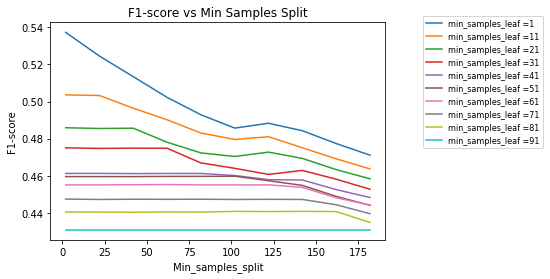

<Figure size 1080x576 with 0 Axes>

In [21]:
for i in min_samples_leaf_values:
    plt.plot(average_values['Min_Samples_Split'][average_values['Min_Samples_Leaf'] == i], average_values['f1_score'][average_values['Min_Samples_Leaf'] == i], label = "min_samples_leaf =" + str(i))
plt.legend(prop={'size': 8}, bbox_to_anchor=(1.1, 1.05))
plt.title("F1-score vs Min Samples Split")
plt.ylabel("F1-score")
plt.xlabel("Min_samples_split")
plt.figure(figsize=(15,8))
plt.show()

### Plus 2 Standard Deviation from Cross-Validation

In [22]:
std_deviation = plotting2.groupby(['Min_Samples_Split','Min_Samples_Leaf']).std().reset_index()

In [23]:
plus2std = plotting2.groupby(['Min_Samples_Split','Min_Samples_Leaf']).std().reset_index()

In [24]:
plus2std['f1_score'] = average_values['f1_score'] + 2*std_deviation['f1_score']

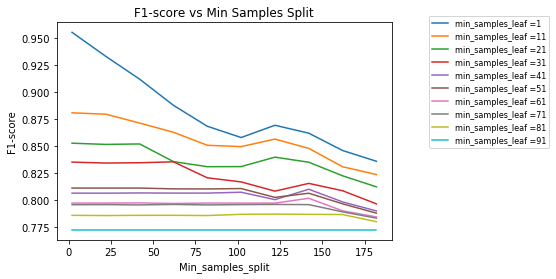

<Figure size 1080x576 with 0 Axes>

In [25]:
for i in min_samples_leaf_values:
    plt.plot(plus2std['Min_Samples_Split'][plus2std['Min_Samples_Leaf'] == i], plus2std['f1_score'][plus2std['Min_Samples_Leaf'] == i], label = "min_samples_leaf =" + str(i))
plt.legend(prop={'size': 8}, bbox_to_anchor=(1.1, 1.05))
plt.title("F1-score vs Min Samples Split")
plt.ylabel("F1-score")
plt.xlabel("Min_samples_split")
plt.figure(figsize=(15,8))
plt.show()

### Minus 2 Standard Deviation from Cross-Validation

In [26]:
minus2std = plotting2.groupby(['Min_Samples_Split','Min_Samples_Leaf']).std().reset_index()

In [27]:
minus2std['f1_score'] = average_values['f1_score'] - 2*std_deviation['f1_score']

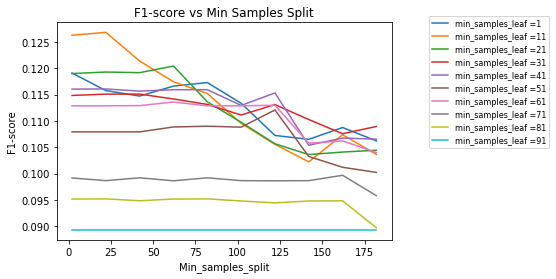

<Figure size 1080x576 with 0 Axes>

In [28]:
for i in min_samples_leaf_values:
    plt.plot(minus2std['Min_Samples_Split'][minus2std['Min_Samples_Leaf'] == i], minus2std['f1_score'][minus2std['Min_Samples_Leaf'] == i], label = "min_samples_leaf =" + str(i))
plt.legend(prop={'size': 8}, bbox_to_anchor=(1.1, 1.05))
plt.title("F1-score vs Min Samples Split")
plt.ylabel("F1-score")
plt.xlabel("Min_samples_split")
plt.figure(figsize=(15,8))
plt.show()

### Best hyperparameters: min_samples_split = 2,min_samples_leaf=1

In [147]:
dt2 = DecisionTreeClassifier(min_samples_split = 2,min_samples_leaf=1).fit(x_train_balanced, y_train_balanced)
y_pred = dt2.predict(x_test)
f1_score(y_test, y_pred, average = 'macro')

0.5280264594035883

In [67]:
data.columns

Index(['EVENT_ID', 'median_income', 'population_density',
       'housing_units_density', 'duration', 'weekend', 'sin_time', 'cos_time',
       'sin_date', 'cos_date', 'tornado_intensity', 'tornado_area',
       'average_range', 'minimum_range', 'average_latitude',
       'average_longitude', 'percent_land', 'multi_vortex',
       'multiclass_casualties'],
      dtype='object')

In [68]:
dt2.feature_importances_

array([0.032394  , 0.02404721, 0.02496007, 0.03978793, 0.03420599,
       0.00870824, 0.02802882, 0.03453747, 0.04188069, 0.02638684,
       0.27985777, 0.15224798, 0.06213723, 0.11665426, 0.02352191,
       0.03140345, 0.03771717, 0.00152295])

### Random Forest Classifier

### Default Parameters

In [172]:
default_parameters = RandomForestClassifier().fit(x_train_balanced, y_train_balanced)
y_pred = default_parameters.predict(x_test)

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Confusion Matrix

In [168]:
array = confusion_matrix(y_test, y_pred)

In [169]:
[array[i]/sum(array[i]) for i in range(len(array))]

[array([0.94448557, 0.05292376, 0.00259067]),
 array([0.5959596 , 0.36363636, 0.04040404]),
 array([0.03703704, 0.59259259, 0.37037037])]

F1 Score

In [173]:
f1_score(y_test, y_pred, average = 'macro')

0.6002013489326139

### Tuning on n_estimators and max_depth

In [159]:
estimators = [10,100,500,1000]
maxdepth = [None,4,6,8,10]

Note: this step takes approx 10 mins to run and slows down my machine

In [160]:
plotting_data = []
for i in estimators:
    for j in maxdepth:
        dt = RandomForestClassifier(n_estimators = i, max_depth = j).fit(x_train_balanced, y_train_balanced)
        y_pred = dt.predict(x_test)
        row = [i ,j, f1_score(y_test, y_pred, average = 'macro')]
        plotting_data.append(row)

In [161]:
pd.DataFrame(plotting_data)[pd.DataFrame(plotting_data)[2] == pd.DataFrame(plotting_data)[2].max()]

,0,1,2
5,100,NaN,0.618752


### Best parameters - default settings: n_estimators = 100, max_depth = None

In [179]:
rfclf = RandomForestClassifier(n_estimators = 100, max_depth = None).fit(x_train_balanced, y_train_balanced)
y_pred = rfclf.predict(x_test)


In [181]:
f1_score(y_test, y_pred, average = 'macro')

0.5952321879005913

In [164]:
array = confusion_matrix(y_test, y_pred)

In [165]:
array

array([[2561,  136,    5],
       [ 115,   78,    5],
       [   1,   15,   11]])

In [166]:
[array[i]/sum(array[i]) for i in range(len(array))]

[array([0.94781643, 0.05033309, 0.00185048]),
 array([0.58080808, 0.39393939, 0.02525253]),
 array([0.03703704, 0.55555556, 0.40740741])]